Just as naive Bayes is a good starting point for classification tasks, linear regression models are a good starting point for regression tasks. Such models are popular because they can be fit very quickly, and are very interpretable. You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data. A straight-line fit is a model of the form

$y=ax+b$

where $a$ is commonly known as the slope, and $b$ is commonly known as the intercept.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

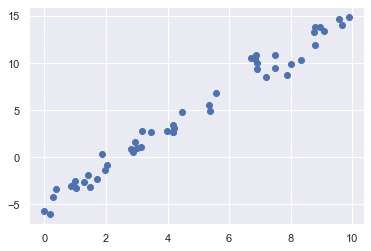

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line:

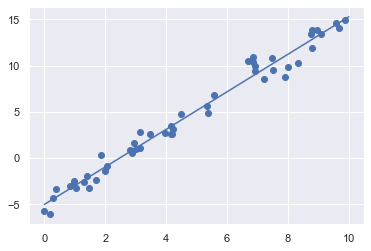

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore. Here the relevant parameters are coef_ and intercept_:

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.027208810360695
Model intercept: -4.998577085553202


We see that the results are very close to the inputs, as we might hope.

The LinearRegression estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form

$y=a_0+a_1x_1+a_2x_2+\cdots$

where there are multiple $x$ values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000127
[ 1.5 -2.   1. ]


Here the $y$ data is constructed from three random x
 values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single LinearRegression estimator to fit lines, planes, or hyperplanes to our data. It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

# Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to basis functions. 

The idea is to take our multidimensional linear model:

$y=a_0+a_1x_1+a_2x_2+a_3x_3+\cdots$

and build the $x_1,x_2,x_3$, and so on, from our single-dimensional input $x$. That is, we let $x_n=f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x)=x^n$, our model becomes a polynomial regression:

$y=a_0+a_1x+a_2x^2+a_3x^3+\cdots$

Notice that this is still a linear model—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other. What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

## Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the PolynomialFeatures transformer:

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value. This new, higher-dimensional data representation can then be plugged into a linear regression.

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. For example, here is a sine wave with noise:

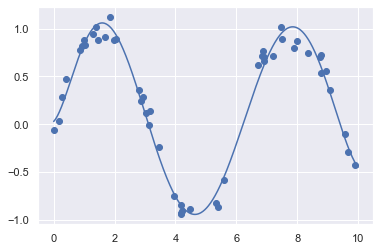

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

## Gaussian basis functions

Of course, other basis functions are possible. For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases.

These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them.

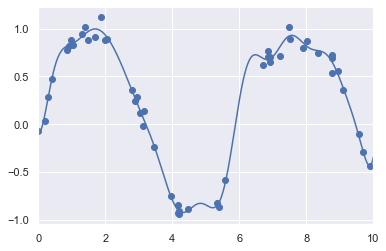

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

# Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting.

For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

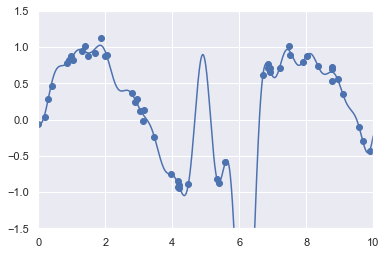

In [10]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

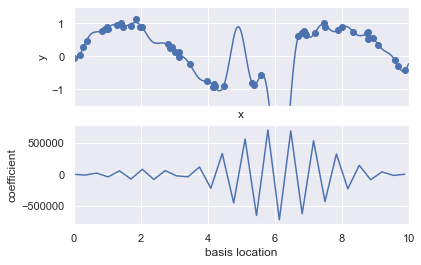

In [11]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function at each location. This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters. Such a penalty is known as regularization, and comes in several forms.

## Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be

$P= \alpha\sum_{n=1}^N \theta_n^2$

where $\alpha$ is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator:

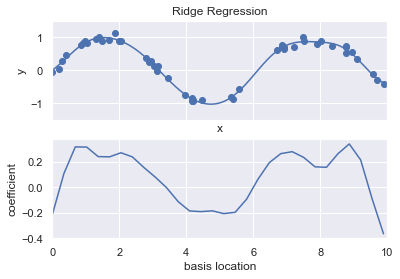

In [12]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model. In the limit $\alpha\rightarrow0$, we recover the standard linear regression result; in the limit $\alpha\rightarrow\infty$ , all model responses will be suppressed. One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

## Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$P=\alpha\sum_{n=1}^N|\theta_n|$

Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

/Users/hiram/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002135815870488389, tolerance: 0.002065280097246271
  model = cd_fast.enet_coordinate_descent(


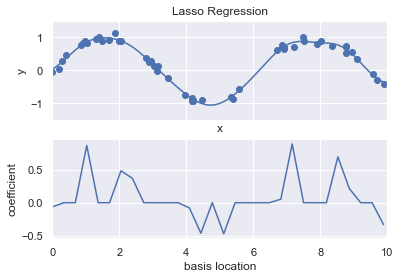

In [13]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation

# Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor. Fortunately, the NOAA makes available their daily weather station data (I used station ID USW00024233) and we can easily use Pandas to join the two data sources. We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning. As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

In [14]:
import pandas as pd
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [15]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

The patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [16]:
daily

,Total
Date,
2012-10-03,14084.0
2012-10-04,13900.0
2012-10-05,12592.0
2012-10-06,8024.0
2012-10-07,8568.0
...,...
2020-11-26,1352.0
2020-11-27,3708.0
2020-11-28,1698.0


In [17]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

We might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

<ipython-input-19-2ee2567719a5>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


(8.0, 17.0)

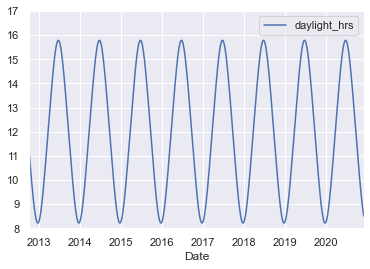

In [19]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data. In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [20]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to mm
weather['PRCP'] /= 10
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000,5.60,1
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000,5.65,1
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000,5.95,1
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000,6.05,1
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000,6.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,1352.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.627583,0.000,4.65,1
2020-11-27,3708.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.596816,0.000,4.75,1
2020-11-28,1698.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.567112,0.002,4.20,0


Finally, let's add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [21]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [22]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data. We will set fit_intercept = False, because the daily flags essentially operate as their own day-specific intercepts:

In [23]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

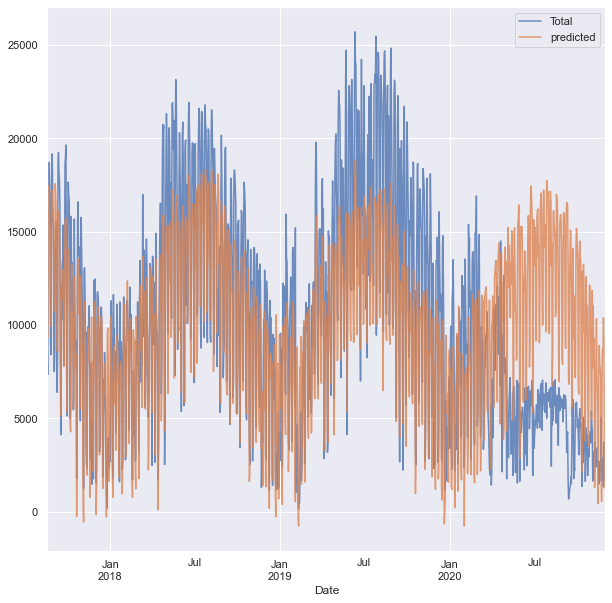

In [24]:
daily[['Total', 'predicted']][-1200:].plot(alpha=0.8,figsize=(10,10));

It is evident that we have missed some key features, especially during the summer time. Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures). Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [25]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              -318.116773
Tue               159.767253
Wed                85.283673
Thu              -415.751821
Fri             -1617.433935
Sat             -6671.522496
Sun             -6993.587974
holiday         -4429.748381
daylight_hrs      356.127591
PRCP           -26308.031984
dry day          2093.736613
Temp (C)         1541.352492
annual           -186.645015
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [26]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [27]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

               effect   error
Mon            -318.0   375.0
Tue             160.0   381.0
Wed              85.0   372.0
Thu            -416.0   370.0
Fri           -1617.0   376.0
Sat           -6672.0   379.0
Sun           -6994.0   384.0
holiday       -4430.0   412.0
daylight_hrs    356.0    39.0
PRCP         -26308.0  2189.0
dry day        2094.0   140.0
Temp (C)       1541.0    95.0
annual         -187.0    33.0


Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

NOTE! On 2020 we have some differences on the predicted value and the actual value of Bicycle traffic. This is because our model does not consider the COVID outbreak!!!